# Tensorflow practical, part 2, multilayer perceptron

Implement the multilayer perceptron for multiclass classification and train it for sci-kit learn “Labeled Faces in the Wild” dataset which has 7 classes.

* Train the network with mini-batch gradient descend. Choose the batch size that works best for you.
* Compute the confusion matrix.
* Test several different optimizers and choose the one which leads to the fastest convergence.
* Experiment with the way you initialize the W values. Print values for dL/dW and confirm that the gradients of ```tanh``` are zero when the initial weights are from zero to one.
* Try using different non-linearities for the hidden layer and compare the results.
* Try to add more hidden layers. Does it help to improve the results. What is the optimal number of the hidden layers for this dataset?

In [360]:
% matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

batch_size = 10
classes = 7
n_epoch = 40

# set random seed to reproduce the results if necessary
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

# def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
#         plt.title(titles[i], size=12)
#         plt.xticks(())
#         plt.yticks(())

# def title(y_test, target_names, i):
#     true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
#     return 'label: %s' % (true_name)

# prediction_titles = [title(y_test, target_names, i)
#                      for i in range(y_test.shape[0])]

# # plot_gallery(X_test, prediction_titles, h, w)

y_train = tf.one_hot(y_train, n_classes)
y_test = tf.one_hot(y_test, n_classes)
y_train = y_train.eval()
y_test = y_test.eval()


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
X_train.shape:  (966, 1850)
X_test.shape:  (322, 1850)
y_train.shape:  (966,)
y_test.shape:  (322,)


Epoch: 0, Loss: 1.828980
Epoch: 1, Loss: 1.773801
Epoch: 2, Loss: 1.770318
Epoch: 3, Loss: 1.769105
Epoch: 4, Loss: 1.768480
Epoch: 5, Loss: 1.768096
Epoch: 6, Loss: 1.768014
Epoch: 7, Loss: 1.768538
Epoch: 8, Loss: 1.768168
Epoch: 9, Loss: 1.767910
Epoch: 10, Loss: 1.767721
Epoch: 11, Loss: 1.767576
Epoch: 12, Loss: 1.767461
Epoch: 13, Loss: 1.767367
Epoch: 14, Loss: 1.767290
Epoch: 15, Loss: 1.767233
Epoch: 16, Loss: 1.767170
Epoch: 17, Loss: 1.767122
Epoch: 18, Loss: 1.767080
Epoch: 19, Loss: 1.767044
Epoch: 20, Loss: 1.767011
Epoch: 21, Loss: 1.766982
Epoch: 22, Loss: 1.766956
Epoch: 23, Loss: 1.766932
Epoch: 24, Loss: 1.766911
Epoch: 25, Loss: 1.766891
Epoch: 26, Loss: 1.766873
Epoch: 27, Loss: 1.766857
Epoch: 28, Loss: 1.766841
Epoch: 29, Loss: 1.766827
Epoch: 30, Loss: 1.766814
Epoch: 31, Loss: 1.766802
Epoch: 32, Loss: 1.766791
Epoch: 33, Loss: 1.766780
Epoch: 34, Loss: 1.766770
Epoch: 35, Loss: 1.766761
Epoch: 36, Loss: 1.766752
Epoch: 37, Loss: 1.766744
Epoch: 38, Loss: 1.766

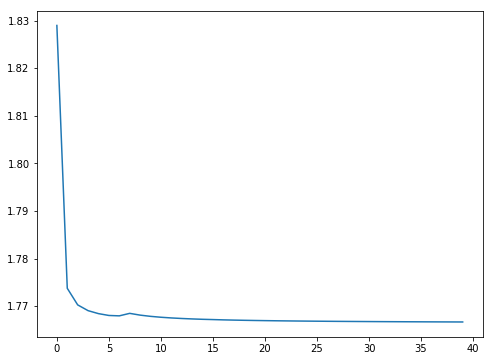

In [362]:
x_input = tf.placeholder(tf.float32, shape=[None, n_features])
y_out = tf.placeholder(tf.int32, shape=[None, n_classes])

W1 = tf.Variable(tf.random_normal([n_features, 10]) * 1e-4, name="W1")
b1 = tf.Variable(tf.zeros([10]), name="b1")

W2 = tf.Variable(tf.random_normal([10, n_classes]) * 1e-4, name="W2")
b2 = tf.Variable(tf.zeros([n_classes]), name="b2")

layer1_pre = tf.matmul(x_input, W1) + b1
layer1 = tf.nn.sigmoid(layer1_pre)

layer2_pre = tf.matmul(layer1, W2) + b2
layer2 = tf.nn.softmax(layer2_pre)

p = layer2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=p, labels=y_out))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train = optimizer.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_train_epoch = []
    
    for i in range(0, n_epoch):
        loss_train = 0

        rng_minibatches = range(0, X_train.shape[0] - batch_size + 1, batch_size)
    
        for start_idx in rng_minibatches:
            X_train_batch = X_train[start_idx:(start_idx + batch_size)]
            y_train_batch = y_train[start_idx:(start_idx + batch_size)]
            
            train.run(feed_dict={x_input: X_train_batch, y_out: y_train_batch})
            [loss_value] = sess.run([loss], feed_dict={x_input:X_train_batch, y_out: y_train_batch})
        
            loss_train += loss_value
    
        loss_train = loss_train / len(rng_minibatches)
        loss_train_epoch.append(loss_train)
        
        print('Epoch: {}, Loss: {:4f}'.format(i, loss_train))
        
    plt.figure(figsize=(8, 6))
    plt.plot(loss_train_epoch, label='Loss')